In [13]:
# ✨ 1. Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# 📂 2. Load Dataset
# File utama
df_raw = pd.read_excel('[CLASSIFIED] Data Table-17-Final-2-1.xlsx', sheet_name=0, header=[5,6])

# Pilih kolom yang dibutuhkan
cols_to_use = [col for col in df_raw.columns if col[0] in ['THE VISITED PLACES of INTEREST'] or col[0] in [2020, 2021, 2022, 2023, 2024]]
df = df_raw[cols_to_use]
df.columns = ['Tempat Wisata'] + [f"{col[0]}_{col[1]}" for col in df.columns if col[0] != 'THE VISITED PLACES of INTEREST']

In [17]:
# 🧼 3. Tangani Missing Value dan Bersihkan Data

# Buang baris dengan Tempat Wisata kosong (hindari inplace warning)
df = df.dropna(subset=['Tempat Wisata'])

# Definisikan pola regex tanpa tanda kurung () agar tidak muncul UserWarning
exclude_pattern = (
    r"CITY|REGENCY|KABUPATEN|KOTA|JUMLAH|TOTAL|DINAS|GOVERNMENT|"
    r"Oleh-Oleh|Syahbandar|Garuda|Sobek|Kerambitan|Munduk|Celukan|"
    r"Rool|Twin|Festival|Sakenan|Bakau/Mangrove|Nusantara|Sumbul|"
    r"Cupel|Wihara|Porprov|MTF|Utsawa|Pesiar|Kerupit|Azamara|"
    r"Clipper|BBDF|Wanagiri|Pengeragoan"
)

# Hapus baris yang mengandung pola tersebut
df = df[~df['Tempat Wisata'].str.contains(exclude_pattern, case=False, na=False, regex=True)]

# Bersihkan angka ribuan (hapus titik), ubah jadi integer
for col in df.columns[1:]:
    df[col] = df[col].astype(str).str.replace('.', '', regex=False)
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)


In [18]:
# 🔄 4. Transformasi Menjadi Format Panjang
rows = []
for _, row in df.iterrows():
    for year in range(2020, 2025):
        wisnus = row.get(f"{year}_wisnus", 0)
        wisman = row.get(f"{year}_wisman", 0)
        rows.append([row['Tempat Wisata'], year, wisnus, wisman])

final_df = pd.DataFrame(rows, columns=["Tempat Wisata", "Tahun", "Wisnus", "Wisman"])
final_df.insert(0, "ID", range(1, len(final_df)+1))

In [19]:
# 🚫 5. Hapus Tempat Wisata yang Total 0
grouped = final_df.groupby("Tempat Wisata")[["Wisnus", "Wisman"]].sum().reset_index()
to_drop = grouped[(grouped['Wisnus'] == 0) & (grouped['Wisman'] == 0)]['Tempat Wisata'].tolist()
final_df = final_df[~final_df['Tempat Wisata'].isin(to_drop)].copy()
final_df.drop(columns=['ID'], inplace=True)
final_df.insert(0, 'ID', range(1, len(final_df)+1))

In [20]:
# 💾 6. Simpan Dataset Bersih
final_df.to_csv("data_wisata_cleaned_filtered.csv", index=False, encoding='utf-8-sig')

In [22]:
# 🗂️ 7. Gabungkan dengan File Mapping Wilayah
data_path = "data_wisata_cleaned_filtered.csv"
mapping_path = "List Tempat wisata dan wilayahnya.xlsx"

df_data = pd.read_csv(data_path)
df_mapping = pd.read_excel(mapping_path)

df_mapping_long = df_mapping.melt(var_name="Wilayah", value_name="Tempat Wisata")
df_mapping_long.dropna(inplace=True)
df_mapping_long["Tempat Wisata"] = df_mapping_long["Tempat Wisata"].str.strip()
df_mapping_long["Wilayah"] = df_mapping_long["Wilayah"].str.replace(":", "", regex=False).str.strip()

df_merged = pd.merge(df_data, df_mapping_long, on="Tempat Wisata", how="left")
df_merged = df_merged[['ID', 'Wilayah', 'Tempat Wisata', 'Tahun', 'Wisnus', 'Wisman']]
df_merged.to_csv("data_wisata_marge.csv", index=False)

In [29]:
# 📊 8. Visualisasi Tren per Tempat Wisata
def plot_tren_per_tempat(df, nama_tempat):
    data = df[df['Tempat Wisata'].str.lower() == nama_tempat.lower()]
    if data.empty:
        print(f"Tidak ada data untuk: {nama_tempat}")
        return
    data = data.sort_values("Tahun")

    plt.figure(figsize=(8, 5))
    sns.lineplot(data=data, x='Tahun', y='Wisnus', label='Wisnus', marker='o')
    sns.lineplot(data=data, x='Tahun', y='Wisman', label='Wisman', marker='o')
    plt.title(f"Tren Kunjungan: {nama_tempat}")
    plt.ylabel("Jumlah Pengunjung")
    plt.xlabel("Tahun")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Contoh penggunaan
df = pd.read_csv("data_wisata_cleaned_filtered.csv")
plot_tren_per_tempat(df, "Museum Bali")


Tidak ada data untuk: Museum Bali


C:\Users\Wafid Adzka\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


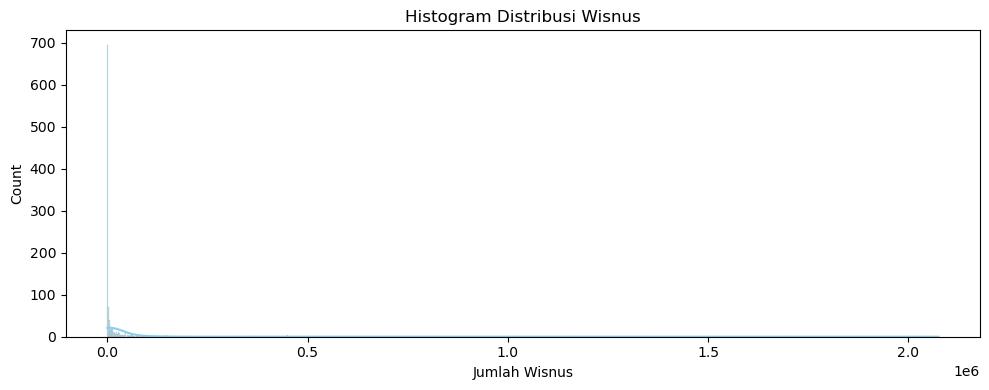

C:\Users\Wafid Adzka\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


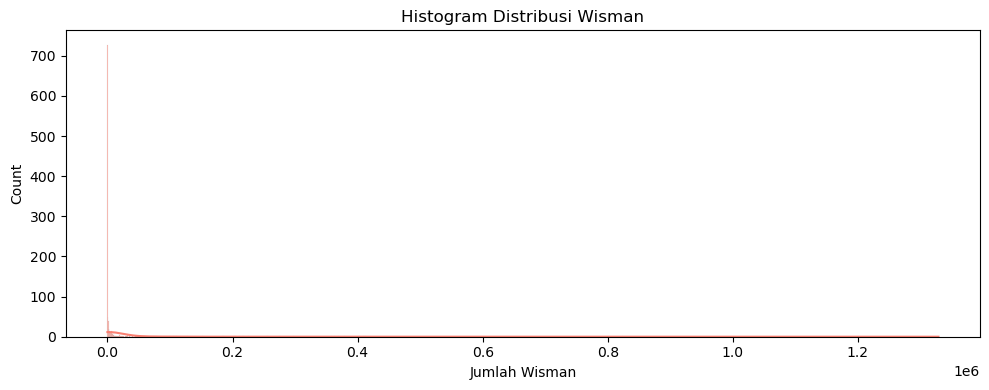

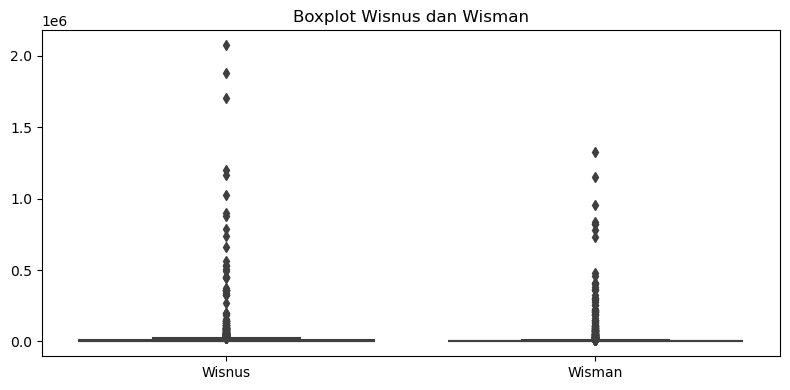

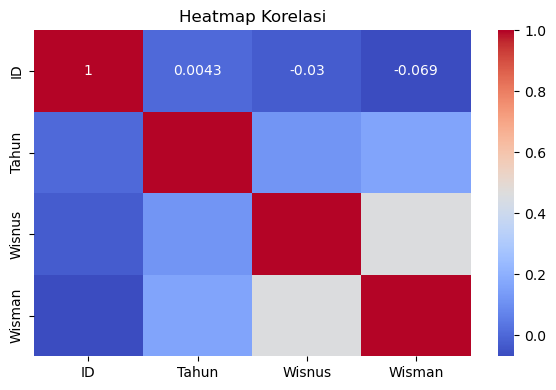

In [27]:
# 📉 9. Visualisasi Distribusi Global
def visualisasi_distribusi(df):
    # Histogram Wisnus
    plt.figure(figsize=(10, 4))
    sns.histplot(df['Wisnus'], kde=True, color='skyblue')
    plt.title("Histogram Distribusi Wisnus")
    plt.xlabel("Jumlah Wisnus")
    plt.tight_layout()
    plt.show()

    # Histogram Wisman
    plt.figure(figsize=(10, 4))
    sns.histplot(df['Wisman'], kde=True, color='salmon')
    plt.title("Histogram Distribusi Wisman")
    plt.xlabel("Jumlah Wisman")
    plt.tight_layout()
    plt.show()

    # Boxplot Wisnus dan Wisman
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df[['Wisnus', 'Wisman']])
    plt.title("Boxplot Wisnus dan Wisman")
    plt.tight_layout()
    plt.show()

    # Heatmap korelasi - aman jika tidak ada data numerik
    numeric_df = df.select_dtypes(include=[np.number])
    corr_matrix = numeric_df.corr()

    if corr_matrix.empty or corr_matrix.shape[0] < 2:
        print("⚠️ Korelasi tidak bisa ditampilkan (tidak cukup data numerik).")
    else:
        plt.figure(figsize=(6, 4))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
        plt.title("Heatmap Korelasi")
        plt.tight_layout()
        plt.show()

visualisasi_distribusi(df)